**Things to extract**

~~- Utility Name~~
~~- Issued Date~~

~~- Company Name~~
~~- Street~~
~~- City~~
~~- State~~
~~- Zip~~


~~- Electric Choice ID#~~
~~- Rate Code~~

~~- Usage~~
~~- Supplier~~


In [19]:
import pdfplumber
import pandas as pd
# import os

In [20]:
# with os.scandir('Bills/') as entries:
#     for entry in entries:
#         print(entry.name)

In [83]:
### FIRST PAGE ###

def setAddressBoundingBox(page):
    
    #get page height and width for box coordinate calculations
    page_height = page.height
    page_width = page.width
    
    #address box is near second top quarter
    top_half = page.height/2
    top_quarter = page.height/4
    second_quarter = top_half - top_quarter
    
    #coordinates of the address box
    address_box_left = (page.width//2) - 20
    address_box_top = second_quarter - 75
    address_box_right = page.width
    address_box_bottom = (page.height//2) -215
    
    address_bounding_box = (address_box_left,address_box_top,address_box_right,address_box_bottom)
    
    return address_bounding_box

def extractAddressBoxText(page, address_bounding_box):
    
    address_extract_text = page.crop(address_bounding_box).extract_text(x_tolerance=1)
    
    return address_extract_text

def setCompanyName(address_extract):
    
    company_name_text = address_extract.splitlines()[0]
    
    return company_name_text
    
def setStreet(address_extract):

    street_text = address_extract.splitlines()[1]
    
    return street_text

def setCityStateZIP(address_extract):
    
    city_state_zip_text = address_extract.splitlines()[2]
    city_state_zip_text = city_state_zip.replace(',', '')
    
    city_text = city_state_zip.split(' ')[0]
    state_text =  city_state_zip.split(' ')[1]
    zip_code_text =  city_state_zip.split(' ')[2]
    
    return city_text, state_text, zip_code_text

def setAccNum(address_extract): 
    
    acc_num_text = address_extract.splitlines()[3]
    acc_num_text = acc_num_text.split('#')[1]
    acc_num_text = acc_num_text.strip()
    
    return acc_num_text

def setIssuedDate(address_extract):
    
    issued_date_text = address_extract.splitlines()[4]
    issued_date_text = issued_date_text.split(':')[1]
    issued_date_text = issued_date_text.strip()
    
    return issued_date_text

def setElectricSupplyBoundingBox(page):
    
    top_half = page.height/2
    top_quarter = page.height/4
    second_quarter = top_half - top_quarter

    electric_supply_box_top  = second_quarter - 75
    electric_supply_box_bottom = (page.height//2) - 215
    electric_supply_box_left = (first_page.width//2) - 130
    electric_supply_box_right = (first_page.width//2)
    
    electric_supply_bounding_box = (electric_supply_box_left,electric_supply_box_top,electric_supply_box_right,electric_supply_box_bottom)
    
    return electric_supply_bounding_box

def extractElectricSupplyBoxText(page, electric_supply_bounding_box):
    
    electric_supply_extract_text = page.crop(electric_supply_bounding_box).extract_text(x_tolerance=1)
    
    return electric_supply_extract_text

def setElectricSupplier(electric_supply_extract_text):
    
    electric_supplier_text = electric_supply_extract.splitlines()[1]
    
    return electric_supplier_text

def setElectricChoiceID(electric_supply_extract_text):
    
    electric_choice_id_text = electric_supply_extract.splitlines()[4]
    electric_choice_id_text = electric_choice_id_text.split('Electric Choice ID:')[1].strip()
    
    return electric_choice_id_text

def setUtilityName(page):
    
    page_extract = page.extract_text(x_tolerance=1, y_tolerance=1)
    utility_name_text = first_page_extract.splitlines()[-6]
    
    return utility_name_text

def setRateBoundingBox(page):
    
    rate_box_left = 20
    rate_box_top = (page.width//4) + 5
    rate_box_right = (page.width//2) - 100
    rate_box_bottom = (page.width//4) + 50
    rate_bounding_box = (rate_box_left, rate_box_top, rate_box_right, rate_box_bottom)
    
    return rate_bounding_box
    
def extractRateBoxText(page, rate_bounding_box):
    
    rate_extract_text = second_page.crop(rate_bounding_box).extract_text(x_tolerance = 1)
    
    return rate_extract_text

def setRate(rate_extract):
    
    

In [87]:
#file_name = input("Name of PDF file: ")
file_name = 'PII Example 1'
#with pdfplumber.open('Bills/'+ file_name + '.pdf') as pdf:
with pdfplumber.open(f'Bills/{file_name}.pdf') as pdf:
    first_page = pdf.pages[0]
    second_page = pdf.pages[1]
    
    #extracting from address box
#     address_bbox = setAddressBoundingBox(first_page)
    address_extract = extractAddressBoxText(first_page, setAddressBoundingBox(first_page))
    
    company_name = setCompanyName(address_extract)
    street = setStreet(address_extract)
    city, state, zip_code = setCityStateZIP(address_extract)
    acc_num = setAccNum(address_extract)
    issued_date = setIssuedDate(address_extract)
   
    #extracting from electric supply box
#     electric_supply_bbox = setElectricSupplyBoundingBox(first_page)
    electric_supply_extract = extractElectricSupplyBoxText(first_page, setElectricSupplyBoundingBox(first_page))
    
    electric_supplier = setElectricSupplier(electric_supply_extract)
    electric_choice_id = setElectricChoiceID(electric_supply_extract)
    
    #extracting utility name from the bottom of the page
    utility_name = setUtilityName(first_page)
    
   

In [76]:
# ### UNABSTRACTED VERSION ### 

# file_name = input("Name of PDF file: ")
# with pdfplumber.open('Bills/'+ file_name + '.pdf') as pdf:
#     first_page = pdf.pages[0]
#     second_page = pdf.pages[1]

#     ### FIRST PAGE ###

#     #coordinates of the second top quarter of the page
#     top_half_p1 = first_page.height/2
#     top_quarter_p1 = first_page.height/4
#     second_quarter_p1 = top_half_p1 - top_quarter_p1

#     #coordinates of the address box
#     address_box_left = (first_page.width//2) - 20
#     address_box_top = second_quarter_p1 - 75
#     address_box_right = first_page.width
#     address_box_bottom = (first_page.height//2) -215
    
#     # bounding_box expressed as (x0, top, x1, bottom)
#     ## address_bounding_box = ((first_page.width//2) - 20, second_quarter_p1 - 75, first_page.width, (first_page.height//2) -215)
#     address_bounding_box = (address_box_left,address_box_top,address_box_right,address_box_bottom)
#     address_box = first_page.crop(address_bounding_box)
#     address_box.to_image()
    
#     address_extract = first_page.crop(address_bounding_box).extract_text(x_tolerance=1)
    
#    # print(address_extract)
    
#     #### SECOND PAGE ###

#     usage_box_left = (second_page.width//2) - 130
#     usage_box_top = (second_page.height//2) - 180
#     usage_box_right = (second_page.width//2) - 20
#     usage_box_bottom = (second_page.height//2) - 150
#     usage_bounding_box = (usage_box_left,usage_box_top,usage_box_right,usage_box_bottom)

#    # print(second_page.crop(usage_bounding_box).extract_text())
#     usage = second_page.crop(usage_bounding_box).extract_text().splitlines()[0]
#     print(usage) 
        

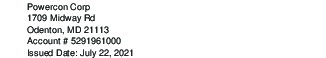

In [22]:
# address_box = first_page.crop(address_bounding_box)
address_box.to_image()

In [23]:
# address_extract = first_page.crop(address_bounding_box).extract_text(x_tolerance=1)
# address_extract  = address_box.extract_text(x_tolerance = 1)

In [24]:
company_name = address_extract.splitlines()[0]
company_name

'Powercon Corp'

In [25]:
street = address_extract.splitlines()[1]
street

'1709 Midway Rd'

In [26]:
city_state_zip = address_extract.splitlines()[2]
city_state_zip = city_state_zip.replace(',', '')

city = city_state_zip.split(' ')[0]
state =  city_state_zip.split(' ')[1]
zip_code =  city_state_zip.split(' ')[2]
print(city, state, zip_code)

Odenton MD 21113


In [27]:
account_number = address_extract.splitlines()[3]
account_number = account_number.split('#')[1]
account_number = account_number.strip()
account_number

'5291961000'

In [28]:
issued_date = address_extract.splitlines()[4]
issued_date = issued_date.split(':')[1]
issued_date = issued_date.strip()
issued_date

'July 22, 2021'

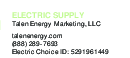

In [29]:
#electric supply bounding box
electric_supply_box_top  = address_box_top
electric_supply_box_bottom = address_box_bottom
electric_supply_box_left = (first_page.width//2) - 130
electric_supply_box_right = (first_page.width//2)

electric_supply_bounding_box = (electric_supply_box_left,electric_supply_box_top,electric_supply_box_right,electric_supply_box_bottom)
electric_supply_box = first_page.crop(electric_supply_bounding_box)
electric_supply_box.to_image()

In [30]:
electric_supply_extract  = electric_supply_box.extract_text(x_tolerance = 1)
print(electric_supply_extract)

ELECTRIC SUPPLY
Talen Energy Marketing, LLC
talenenergy.com
(888) 289-7693
Electric Choice ID: 5291961449


In [31]:
electric_supplier = electric_supply_extract.splitlines()[1]
electric_supplier

'Talen Energy Marketing, LLC'

In [32]:
electric_choice_id = electric_supply_extract.splitlines()[4]
electric_choice_id = electric_choice_id.split(':')[1].strip()
electric_choice_id

'5291961449'

In [33]:
first_page_extract = first_page.extract_text(x_tolerance=1, y_tolerance=1)
utility_name = first_page_extract.splitlines()[-6]
utility_name

'BGE'

In [34]:
#### SECOND PAGE ###

# usage_box_left = (second_page.width//2) - 130
# usage_box_top = (second_page.height//2) - 180
# usage_box_right = (second_page.width//2) - 20
# usage_box_bottom = (second_page.height//2) - 150
# usage_bounding_box = (usage_box_left,usage_box_top,usage_box_right,usage_box_bottom)

# second_page.crop(usage_bounding_box).extract_text()


In [35]:
rate_box_left = 20
rate_box_top = (second_page.width//4) + 5
rate_box_right = (second_page.width//2) - 100
rate_box_bottom = (second_page.width//4) + 50
rate_bounding_box = (rate_box_left, rate_box_top, rate_box_right, rate_box_bottom)

second_page.crop(rate_bounding_box).to_image()

rate_extract = second_page.crop(rate_bounding_box).extract_text(x_tolerance = 1)

#gets the first line after the word 'Service' and remove the leading whitespace and '-'
rate = rate_extract.split('Service')[1].splitlines()[0].replace('-','',1).strip() 
print(rate)

Large General Service - TOU - Schedule GL
Billing Period: Jun 21, 2021 - Jul 21, 2021
Next Scheduled Reading: August 19, 2021
Meter #G159836966 Read on Jul 21

TOU - Schedule GL
